In [1]:
#%pip install --upgrade hyperspectral_gta_data

In [32]:
# Common useful packages
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import copy
import spectral
from sklearn import linear_model

# module that is useful for reloading packages
import importlib

# Scripts associated with the SML4SI textbook
import hyperspectral_gta_data as hsi_data
import scripts_M2 as sm2

# set the directory where data will be downloaded and accessed
# (This directory will be saved in a config file and used each time you use hyperspectral_gta_data, 
# so you don't need to run the 'set_data_dir' function every time you use hyperspectral_gta_data.)
hsi_data.set_data_dir('C:/spectral_data')

## In this notebook, we will introduce unmixing a hyperspectral image using a spectral library

With target detection, we have two data sets:
1. **A hyperspectral image.**
2. **A spectral library.**

The spectral library are usually collected from known materials that we believe are likely to be present in .

The data preparation is the same as for taarget detection, which includes:
1. **Load Data:** Load the image and spectral library.
2. **Check Data Scale:** Check that the iamge and library have the same scale. Ideally, they are both on a 0-1 scale for reflectance units, but:
    i. Sometimes data are stored in 16-bit integer data type to save memory and resources.  In that case, they are often on a 0-1000 scale.
    ii. Often, the values for spectral data are too large or small due to (1) changes in sunlight and shadow, (2) problems in atmospherice correction, converting from radiance to reflectance, or (3) calibration of sensors.
3. **Check Wavelengths:** Check that the image and spectra have wavelengths in the same units (both nanometers or both micrometers) and have the same values.  If the units are different, we simply multiply or divide by 1000 as needed.  If the wavelength values are different, we have to resample the data. Almost always, this means resampling the library to the wavelengths of the image, because the library usually has higher spectral resolution (more bands with more tightly-spaced wavelengths).
4. **Quality Check:** Do a quality check on the data and spectra.  If the light source for either is the sun, then there will be bands where the atmosphere (mostly water vapor) absorbs most of the light.  These need to be removed from the data, and then the resampling is needed as in Step 3.

After these are completed, we will be ready for unmixing.

## Data: Our data will be hyperspectral images over the Cuprite, Nevada area.  Below is known locaitons of minerals present at the surface in this area:

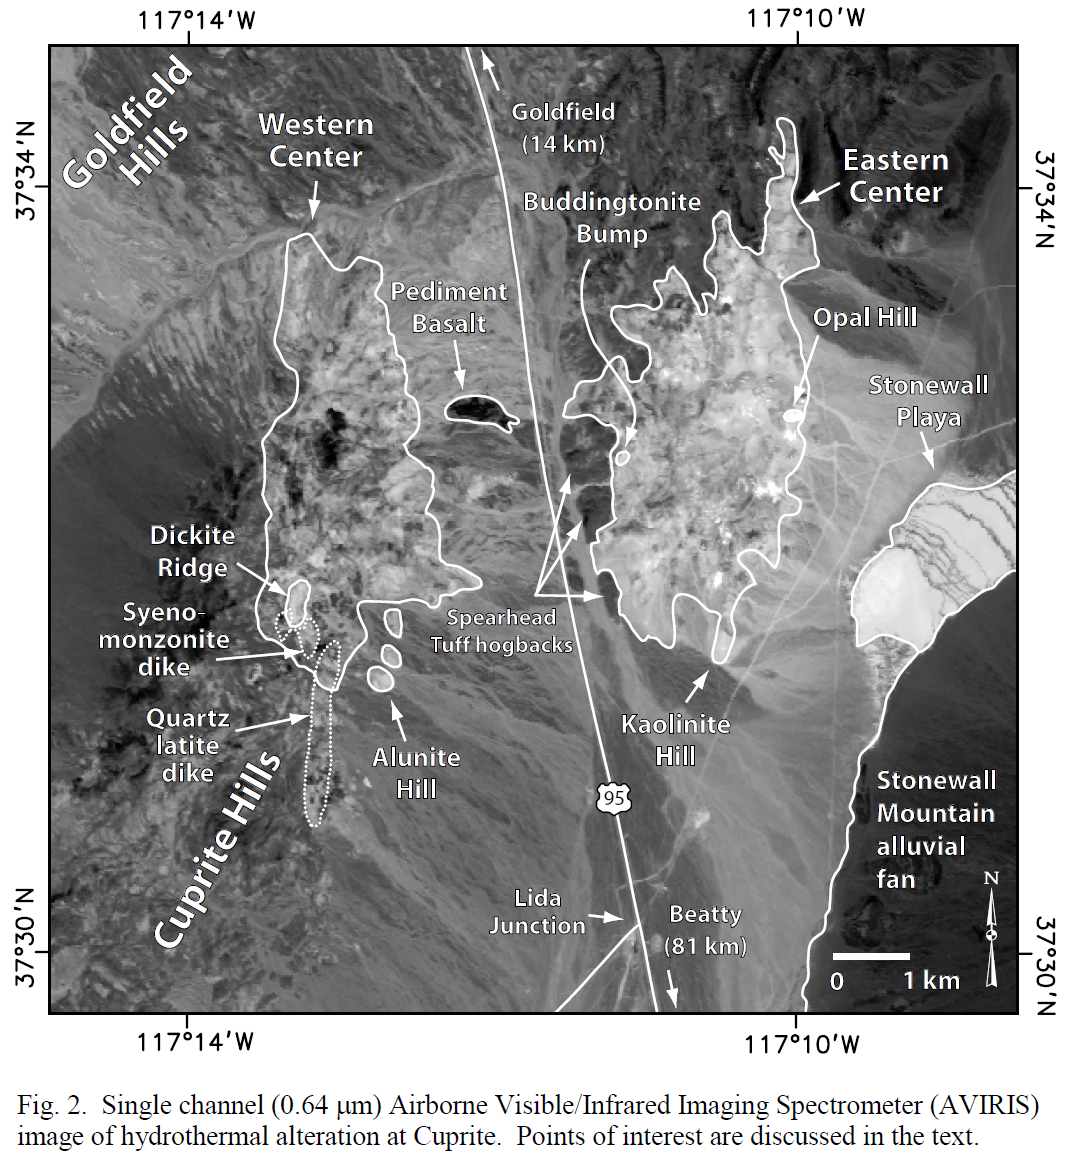

Image from: https://www.usgs.gov/publications/mapping-advanced-argillic-alteration-cuprite-nevada-using-imaging-spectroscopy 

# 1. Download the data

In [3]:
# Here are the datasets available through the hyperspectral_gta_data package
hsi_data.available_datasets()

Available Images:
   WashingtonDC
   MicroscenePolymers
   DetectionImagery_CookeCity_RIT
   VegBaccharisUPWINS
   PaintDetectionUPWINS
   indian_pines
   pavia_centre
   pavia_university
   AVIRIS_Cuprite
   ENMAP_Cuprite
Available Spectral Libraries:
   GHISACONUS_2008_001_speclib
   Microscene_Polymers_Library
   UPWINS_4_16_2024
   Detection_Library_Cooke_City_RIT
   USGS_splib07b


## Download the hyperspectral image

In this case, we will be using a hyperspectral image from the RIT test over Cooke City, Montana. (https://dirsapps.cis.rit.edu/blindtest/)

In [4]:
# Download and use the Cooke Cite image:
hsi_data.download('AVIRIS_Cuprite')
fname = hsi_data.get_fname('AVIRIS_Cuprite')

Available Files:
C:\spectral_data\spectral_images\AVIRIS_Cuprite\AVIRIS_cuprite_ang20200712t201415_subset
C:\spectral_data\spectral_images\AVIRIS_Cuprite\AVIRIS_cuprite_ang20200712t201415_subset.hdr
Primary Image Filename:
C:/spectral_data\spectral_images\AVIRIS_Cuprite/AVIRIS_cuprite_ang20200712t201415_subset


In [5]:
# load the Cooke City hyperspectral iamge
fname = 'C:\\spectral_data\\spectral_images\\AVIRIS_Cuprite\\AVIRIS_cuprite_ang20200712t201415_subset'
fname_hdr = 'C:\\spectral_data\\spectral_images\\AVIRIS_Cuprite\\AVIRIS_cuprite_ang20200712t201415_subset.hdr'

# Open the image and read into an array
im = spectral.envi.open(fname_hdr, fname)
wl_im = np.asarray(im.bands.centers)
# Load the image into memory
im.Arr = im.load()
imArr = im.Arr
print(f'Shape of ImArr = {imArr.shape}')
imList = np.reshape(imArr, (im.nrows*im.ncols, im.nbands))
print(f'Shape of imList = {imList.shape}')

Shape of ImArr = (2000, 550, 372)
Shape of imList = (1100000, 372)


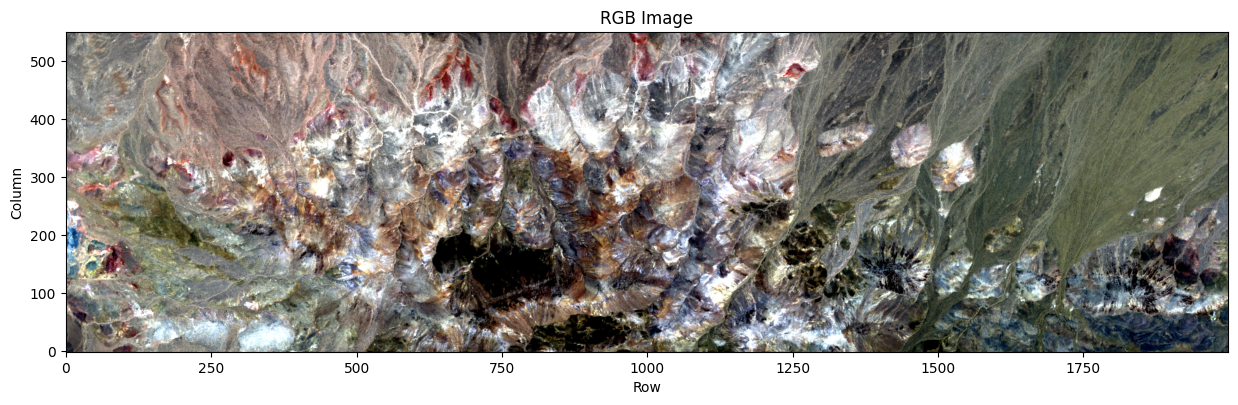

In [6]:
# display the image
sm2.display_RGB(imArr, wl_im, rotate=True)
plt.title('RGB Image');

In [7]:
# explore the image in our hyperspectral image viewer
from hsiViewer import hsi_viewer as hv
#hv.viewer(im)

# Download the Spectral Library for Unmixing

In [8]:
# To download and use the Cooke City spectral library image:
hsi_data.download('USGS_splib07b')
fname = hsi_data.get_fname('USGS_splib07b')

Available Files:
C:\spectral_data\spectral_libraries\USGS_splib07b\splib07b_asdfr.hdr
C:\spectral_data\spectral_libraries\USGS_splib07b\splib07b_asdfr.sli
C:\spectral_data\spectral_libraries\USGS_splib07b\splib07b_asdhr.hdr
C:\spectral_data\spectral_libraries\USGS_splib07b\splib07b_asdhr.sli
C:\spectral_data\spectral_libraries\USGS_splib07b\splib07b_asdng.hdr
C:\spectral_data\spectral_libraries\USGS_splib07b\splib07b_asdng.sli
Primary Image Filename:
C:/spectral_data\spectral_libraries\USGS_splib07b/splib07b_asdfr.sli


In [66]:
fname = 'C:/spectral_data/spectral_libraries/USGS_splib07b/splib07b_asdfr.sli'
fname_hdr = 'C:/spectral_data/spectral_libraries/USGS_splib07b/splib07b_asdfr.hdr'

# Open the image and read into an array
lib = spectral.envi.open(fname_hdr, fname)
wl = np.asarray(im.bands.centers)
# Load the image into memory
names = lib.names
spectra = lib.spectra
wl_lib = np.asarray(lib.bands.centers)

In [67]:
names

['Alizarin_crimson (dk) GDS780',
 'Aluminum brushed 293K',
 'Asphalt GDS376 Blck_Road old',
 'Asphalt_Shingle GDS366 Tan',
 'Asphalt_Shingle GDS367 DkGry',
 'Asphalt_Shingle GDS368 Lgray',
 'Asphalt_Tar GDS346 Blck_Roof',
 'Bone_black GDS808',
 'Brick GDS347 Paving Tan',
 'Brick GDS348 Pave DkBrwngrey',
 'Brick GDS349 Paving Red',
 'Brick GDS350 Dk Red Building',
 'Brick GDS353 Building MedRed',
 'Brick GDS354 Building Lt Gry',
 'Brick GDS355 Paving Dk Gry',
 'Brilliant(Hansa)yellowGDS785',
 'Burlap_Fabric GDS430 Brown',
 'Burnt_umber GDS811',
 'Cadmium_orange_0 GDS786',
 'Cadmium_orange_1 (dk) GDS781',
 'Cadmium_red_2 GDS778',
 'Cadmium_yellow_6 med GDS788',
 'Cardboard GDS371 Brn Corgted',
 'Cedar_Shake GDS357 Fresh',
 'Cedar_Shake GDS358 SlgWeathr',
 'Cedar_Shake GDS359 MedWeathr',
 'Cedar_Shake GDS360 H Weamoss',
 'Cedar_Shake GDS361 HiWeather',
 'Cerium_Oxide 5-9s SPEX 11781',
 'Cerulean_blue GDS797',
 'Cinder_Block GDS356 Lg Grey',
 'Coated_Steel_Girder WTC01-8',
 'Cobalt_blue GD

### Subset the library to only include the minerals, (spectra 249-650)

In [68]:
#names = names[249:650]
#spectra = spectra[249:650,:]

# Check Data Scale

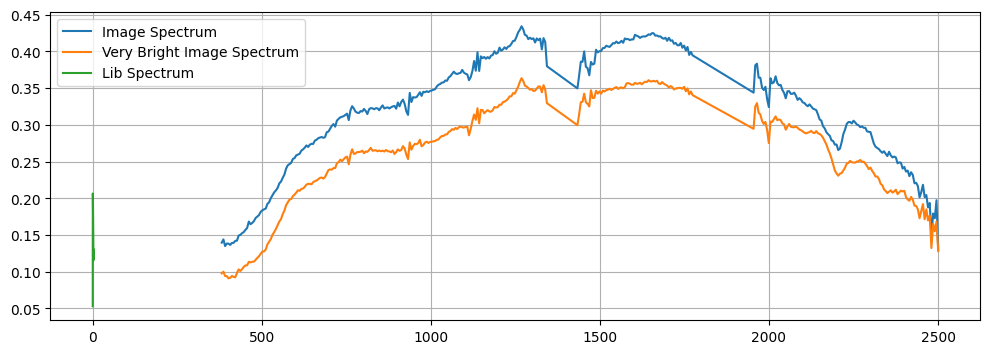

In [69]:
plt.figure(figsize=(12,4))
plt.plot(wl_im, imArr[100,100,:].flatten(), label='Image Spectrum')
plt.plot(wl_im, imArr[172,233,:].flatten(), label='Very Bright Image Spectrum')
plt.plot(wl_lib, spectra[5,:].flatten(), label='Lib Spectrum')
plt.grid()
plt.legend()

### Observation 1: The units on the wavelengths in the library are microns and the units on the wavelengths for the image are nanometers.  We often moodify the library to match the image as a convention, so we will multiply the wavelengths for the library by 1000 to match the image.

### Observation 2: The image and the library reflectance values are both on 0-1 scale.  This is ideal.

In [70]:
wl_lib = wl_lib*1000

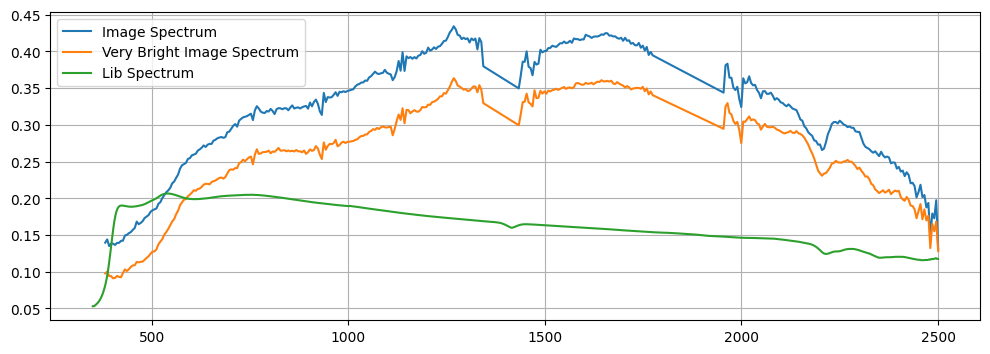

In [71]:
plt.figure(figsize=(12,4))
plt.plot(wl_im, imArr[100,100,:].flatten(), label='Image Spectrum')
plt.plot(wl_im, imArr[172,233,:].flatten(), label='Very Bright Image Spectrum')
plt.plot(wl_lib, spectra[5,:].flatten(), label='Lib Spectrum')
plt.grid()
plt.legend()

# Check wavelengths

In [72]:
print(f'Number of image wavelengths: {len(wl_im)}.')
print(f'Number of library wavelengths: {len(wl_lib)}.')
print('')
print(f'First 10 image wavelengths: {wl_im[:10]}.')
print('')
print(f'First 10 library wavelengths: {wl_lib[:10]}.')

Number of image wavelengths: 372.
Number of library wavelengths: 2151.

First 10 image wavelengths: [381.729584 386.739563 391.749573 396.749573 401.759583 406.769562
 411.779572 416.789581 421.799591 426.80957 ].

First 10 library wavelengths: [349.99999 351.00001 352.      352.99999 354.      354.99999 356.00001
 356.99999 358.00001 359.     ].


### Observation: The library spectrum has many more wavelengths than the image.  Also, there is about 14nm between succsive image wavelength and about 1nm between library wavelengths.

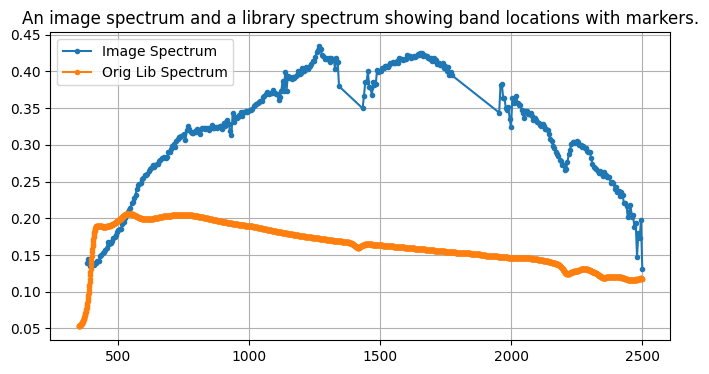

In [73]:
plt.figure(figsize=(8,4))
plt.title('An image spectrum and a library spectrum showing band locations with markers.')
plt.plot(wl_im, imArr[100,100,:].flatten(), marker='.', label='Image Spectrum')
plt.plot(wl_lib, spectra[5,:].flatten(), marker='.', label='Orig Lib Spectrum')
plt.grid()
plt.legend()

### Resampling the library wavelength to match the image.

In [74]:
# Create a BandResampler, which is a function that resamples spectra from one source to match a different source.
# See: https://www.spectralpython.net/class_func_ref.html?highlight=resampling#spectral.algorithms.resampling.BandResampler
# Inputs: the first input is the wavelengths for the spectra that you are going to resample, the second input is the wavelevngths that you want to resample to.
resampler = spectral.BandResampler(wl_lib, wl_im)
spectra_resampled = resampler(spectra.T).T

print(f'The shape of the spectral library is {spectra_resampled.shape}.')
print(f'({spectra_resampled.shape[0]} spectra with {spectra_resampled.shape[1]} bands.)')

The shape of the spectral library is (966, 372).
(966 spectra with 372 bands.)


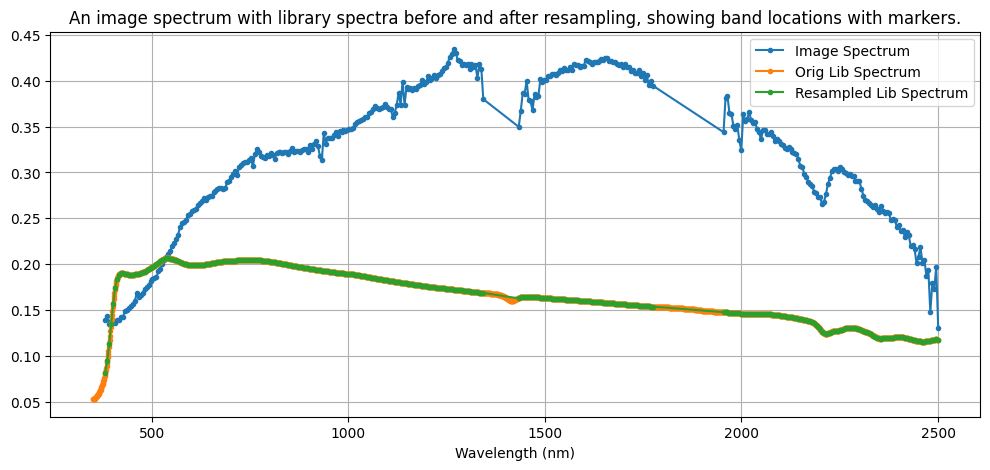

In [75]:
plt.figure(figsize=(12,5))
plt.title('An image spectrum with library spectra before and after resampling, showing band locations with markers.')
plt.plot(wl_im, imArr[100,100,:].flatten(), marker='.', label='Image Spectrum')
plt.plot(wl_lib, spectra[5,:].flatten(), marker='.', label='Orig Lib Spectrum')
plt.plot(wl_im, spectra_resampled[5,:].flatten(), marker='.', label='Resampled Lib Spectrum')
plt.xlabel('Wavelength (nm)')
plt.grid()
plt.legend();

In [76]:
# now that the library is resampled, let's use simple names.
spec = spectra_resampled # spectra from the library, after resampling
wl = wl_im # the wavelengths for the image and the resampled library

# Spectral Unmixing

A *mixed pixel* in a hyperspectral image is a pixel that contains more than one pure material (a mixture of materials).

The process of *unmixing* is the process of determining the pure materials and abuncances that are present in a mixed pixel.

If $x$ is a mixed pixel spectrum and $S$ is an array of library or pixel spectra, then the linear mixing formula is:

$$
x= S \beta + \varepsilon
$$

This can be written as:
$$
\left[
  \begin{array}{c}
    s_1\\
    s_2\\
    \vdots\\
    s_{nb}
  \end{array}
\right]
 = 
\left[
  \begin{array}{cccc}
    S_{1,1} & S_{1,2} & \cdots & S_{1,k}\\
    S_{2,1} & S_{2,2} & \cdots & S_{2,k}\\
            & &  \vdots & & \\ 
    S_{nb,1} & S_{nb,2} & \cdots & S_{nb,k}\\
  \end{array}
\right]
\left[
  \begin{array}{c}
    \beta_1\\
    \beta_2\\
    \vdots\\
    \beta_{nb}
  \end{array}
\right]
+
\left[
  \begin{array}{c}
    \varepsilon_1\\
    \varepsilon_2\\
    \vdots\\
    \varepsilon_{nb}
  \end{array}
\right]
$$

Each coefficient in $\beta$ is the fraction of the mixed pixel spectrum that comes from the corresponding endmember. These must be positive. Optional added restrictions are that the coefficients sum to one or are all less than or equal to 1.

We will use LinearRegression from sklean. Here are the inputs to the fit method:

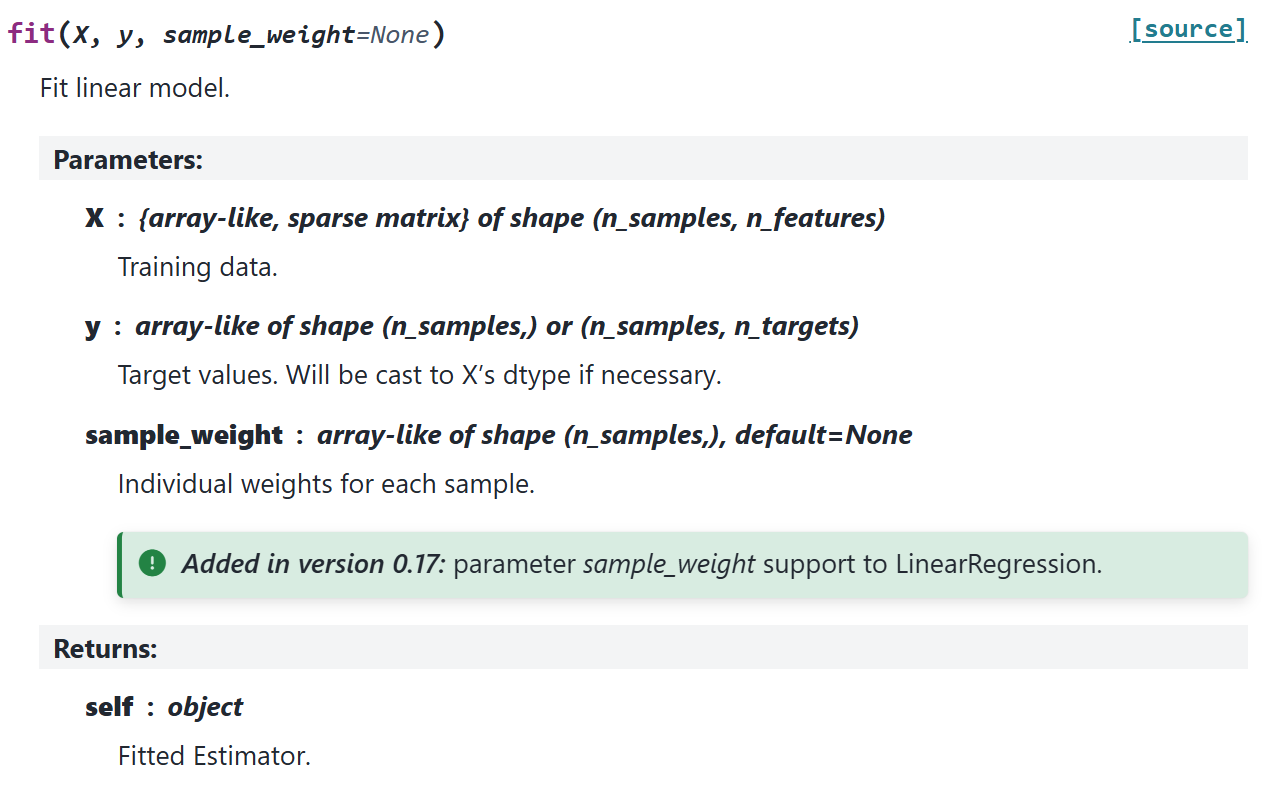

In [77]:
# check the data shape
print(f'ImList shape: {imList.shape}')
print(f'Spectral Library spe shape: {spec.shape}')
X = spec.T
y = imList.T

print(f'Each library spectrum is a feature, so: n_features = {X.shape[1]} (number of predictor variables in each model)')
print(f'Each band is a sample, so: n_samples = {X.shape[0]} (number of observations in each model)')
print(f'Each pixel is a target, so: n_targets = {y.shape[1]} (number of regression models that we will build)')


ImList shape: (1100000, 372)
Spectral Library spe shape: (966, 372)
Each library spectrum is a feature, so: n_features = 966 (number of predictor variables in each model)
Each band is a sample, so: n_samples = 372 (number of observations in each model)
Each pixel is a target, so: n_targets = 1100000 (number of regression models that we will build)


In [78]:
### WHY DO WE NOT WANT TO DO THIS?

# load and fit a linear regression classifier
#clf = linear_model.LinearRegression(fit_intercept=False, copy_X=True, positive=True)
#clf.fit(X,y)

## Unmixing, no coefficient restrictions

## Unmixing with positive coefficients

In [ ]:
# subset the library to use only a few spectra
library_indices = []
indicator_strings = ['dicktite', 'alunite', 'opal', 'monzonite', 'quartz', 'opal', 'buddingtonite', 'kaolunite']
for ind_str in indicator_strings:
    for i,name in enumerate(lib.names):
        if ind_str in name.lower():
            print([i, name.lower()])
            library_indices.append(int(i))

library_indices = np.asarray(library_indices)
library_indices = np.unique(library_indices)
library_indices = np.sort(library_indices)


X_select = X[:,library_indices]
names_sel = []
for i in library_indices:
    names_sel.append(names[i])
print(names_sel)

[284, 'alunite hs295.1b']
[285, 'alunite hs295.3b']
[286, 'alunite hs295.4b']
[287, 'alunite hs295.6']
[288, 'alunite hs295']
[673, 'alunite+dickite mv99-6-26b']
[674, 'alunite-k cu91-217g1 hitemp']
[675, 'alunite0.35k+.65na cu91-217h']
[676, 'alunite_k-na cu91-217h1 lowt']
[677, 'alunite_k cu98-5c medtemp']
[678, 'alunite_nh4+jaro nmnh145596a']
[729, 'opalized tuff cu00-15e']
[561, 'quartz hs32.1b']
[562, 'quartz hs32.2b']
[563, 'quartz hs32.3b']
[711, 'illite cu00-5b hi-al+quartz']
[729, 'opalized tuff cu00-15e']
['Alunite HS295.1B', 'Alunite HS295.3B', 'Alunite HS295.4B', 'Alunite HS295.6', 'Alunite HS295', 'Quartz HS32.1B', 'Quartz HS32.2B', 'Quartz HS32.3B', 'Alunite+Dickite MV99-6-26b', 'Alunite-K CU91-217G1 HiTemp', 'Alunite0.35K+.65Na CU91-217H', 'Alunite_K-Na CU91-217H1 LowT', 'Alunite_K CU98-5C MedTemp', 'Alunite_NH4+Jaro NMNH145596A', 'Illite CU00-5B Hi-Al+Quartz', 'Opalized Tuff CU00-15E']


In [87]:
library_indices = [285,673,674,729,562]
X_select = X[:,library_indices]
names_sel = []
for i in library_indices:
    names_sel.append(names[i])
print(names_sel)

['Alunite HS295.3B', 'Alunite+Dickite MV99-6-26b', 'Alunite-K CU91-217G1 HiTemp', 'Opalized Tuff CU00-15E', 'Quartz HS32.2B']


## Unmixing, no coefficient restrictions

In [97]:
# load and fit a linear regression classifier
clf_unrestricted = linear_model.LinearRegression(fit_intercept=False, copy_X=True, positive=False)
clf_unrestricted.fit(X_select,y)

LinearRegression(fit_intercept=False)

In [ ]:
res_unrestricted = clf_unrestricted.coef_
print(res.shape)

result_im_unrestricted = np.reshape(res_unrestricted, (im.nrows,im.ncols,len(names_sel)))
for i in range(len(names_sel)):
    plt.figure(figsize=(15,5))    
    plt.imshow(np.flip(np.rot90(result_im_unrestricted[:,:,i]), axis=0), cmap='jet')
    plt.gca().invert_yaxis()  
    plt.colorbar()
    plt.xlabel('Row');
    plt.ylabel('Column');
    plt.title(f'Abundance for {names_sel[i]}')

## Unmixing, positive coefficients only

In [93]:
# load and fit a linear regression classifier
clf = linear_model.LinearRegression(fit_intercept=False, copy_X=True, positive=True)
clf.fit(X_select,y[:,:10000])

LinearRegression(fit_intercept=False, positive=True)

In [90]:
print(f'5 seconds for {10000} pixels')
print(f'Estimated time: {y.shape[1]*(5/10000)} seconds')

5 seconds for 10000 pixels
Estimated time: 550.0 seconds


In [94]:
# load and fit a linear regression classifier
clf = linear_model.LinearRegression(fit_intercept=False, copy_X=True, positive=True)
clf.fit(X_select,y)

LinearRegression(fit_intercept=False, positive=True)

In [ ]:
res = clf.coef_
print(res.shape)

result_im = np.reshape(res, (im.nrows,im.ncols,len(names_sel)))
for i in range(len(names_sel)):
    plt.figure(figsize=(15,5))    
    plt.imshow(np.flip(np.rot90(result_im[:,:,i]), axis=0), cmap='jet')
    plt.gca().invert_yaxis()  
    plt.xlabel('Row');
    plt.ylabel('Column');
    plt.title(f'Abundance for {names_sel[i]}')

In [ ]:
mineral_image = result_im[:,:,[1,3,4]]
plt.figure(figsize=(15,50))
plt.imshow(mineral_image)